In [ ]:
# Mount Google Colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd '/content/gdrive/My Drive/Masters_Thesis'


Mounted at /content/gdrive
/content/gdrive/My Drive/Masters_Thesis


In [ ]:
!pip install stepmix # library used to build LCA model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from stepmix.stepmix import StepMix

from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

np.random.seed(42)

In [ ]:
# Provide the filename of your Excel file
file_name = 'preprocessed_reduced_pcaCV.xlsx'

# Read the Excel file into a pandas DataFrame
reduced_pcaSC = pd.read_excel(file_name)

#Splitting data into answers for work_styles test

In [ ]:
work_styles = reduced_pcaSC[reduced_pcaSC['maingroup'] == 'tests.workstyles.title']
len(work_styles.question_id.unique())

# Above gives: array(['Gerichtheid op mensen', 'Sociale invloed', 'Aanpassingsvermogen',
#       'Zorgvuldigheid', 'Praktisch inzicht', 'Prestatiegerichtheid',
#       'Onafhankelijkheid'], dtype=object)

#Is the same as:
# People orientation, Social influence, Adaptability, diligence, Practical insight, Performance orientation, Independence

12

In [ ]:
# Specify the column names you want to keep
columns_to_keep = ['question_id', 'maingroup', 'level1subgroup']

# Subset the DataFrame using the specified columns
wrk_s = work_styles.loc[:, columns_to_keep]

wrk_s = wrk_s.drop(['maingroup'], axis=1)
qs = wrk_s.drop_duplicates(subset='question_id')
qs = qs.sort_values('level1subgroup')
qs

# Create the 'short_name' column
qs['short_name'] = ''

# Same process as shown and explained in personality notebook
count_peo_o = 1
count_si = 1
count_a2 = 1
count_d2 = 1
count_pi = 1
count_per_o = 1
count_i3 = 1

for index, row in qs.iterrows():
    if row['level1subgroup'] == 'Gerichtheid op mensen':
        qs.at[index, 'short_name'] = f'peo{count_peo_o}'
        count_peo_o += 1

    elif row['level1subgroup'] == 'Sociale invloed':
        qs.at[index, 'short_name'] = f'sin{count_si}'
        count_si += 1

    elif row['level1subgroup'] == 'Aanpassingsvermogen':
        qs.at[index, 'short_name'] = f'ada{count_a2}'
        count_a2 += 1

    elif row['level1subgroup'] == 'Zorgvuldigheid':
        qs.at[index, 'short_name'] = f'dil{count_d2}'
        count_d2 += 1

    elif row['level1subgroup'] == 'Praktisch inzicht':
        qs.at[index, 'short_name'] = f'pin{count_pi}'
        count_pi += 1

    elif row['level1subgroup'] == 'Prestatiegerichtheid':
        qs.at[index, 'short_name'] = f'per{count_per_o}'
        count_per_o += 1

    else:
        qs.at[index, 'short_name'] = f'inde{count_i3}'
        count_i3 += 1

qs

,question_id,level1subgroup,short_name
77,2406,Aanpassingsvermogen,ada1
78,2405,Aanpassingsvermogen,ada2
79,2404,Aanpassingsvermogen,ada3
73,2403,Gerichtheid op mensen,peo1
74,2402,Gerichtheid op mensen,peo2
75,2401,Gerichtheid op mensen,peo3
82,2397,Prestatiegerichtheid,per1
83,2398,Prestatiegerichtheid,per2
84,2399,Prestatiegerichtheid,per3
76,2400,Sociale invloed,sin1


In [ ]:
n_qs = qs.drop(['level1subgroup'], axis=1)

# merging (left join) studeies to orginal dataframe
new_qs = pd.merge(work_styles, n_qs, on='question_id', how='left')
new_qs.head(3)

,question_id,dossier_id,answeredTest_id,question,type,label,datetime,maingroup,maingroup_id,faculty,level1subgroup,level1subgroup_id,answer,short_name
0,2403,1532,13165,question.id_2403,likert/likert6puntsmatepositief,Om mijn werk goed te doen is het belangrijk om...,2021-09-15 13:53:51,tests.workstyles.title,516,Faculteit Betawetenschappen,Gerichtheid op mensen,526,1.0,peo1
1,2402,1532,13165,question.id_2402,likert/likert6puntsmatepositief,Om mijn werk goed te doen is het belangrijk om...,2021-09-15 13:53:52,tests.workstyles.title,516,Faculteit Betawetenschappen,Gerichtheid op mensen,526,0.8,peo2
2,2401,1532,13165,question.id_2401,likert/likert6puntsmatepositief,Om mijn werk goed te doen is het belangrijk om...,2021-09-15 13:53:52,tests.workstyles.title,516,Faculteit Betawetenschappen,Gerichtheid op mensen,526,1.0,peo3


In [ ]:
# Create pivot table for Questions
qs_data = pd.pivot_table(new_qs, values='answer', index='dossier_id', columns='short_name')

# Reset the index of 'qs_data'
qs_data = qs_data.reset_index()
qs_data = qs_data.rename_axis(None, axis=1)

# Remove NAN values
qs_data.replace('', np.nan, inplace=True)
qs_data = qs_data.dropna()
qs_data

,dossier_id,ada1,ada2,ada3,dil1,dil2,peo1,peo2,peo3,per1,per2,per3,sin1
0,1532,0.4,0.8,1.0,0.8,1.0,1.0,0.8,1.0,0.4,0.8,0.6,0.6
1,1649,0.8,0.6,0.8,0.6,0.4,0.6,0.8,1.0,0.2,0.6,0.4,0.4
2,2112,0.6,0.8,0.2,0.4,0.4,0.8,0.8,1.0,0.2,0.8,0.8,0.8
3,30690,0.6,0.6,0.6,0.8,0.8,0.8,0.4,0.6,0.8,0.6,0.8,0.8
4,42388,0.6,0.8,0.8,0.8,0.8,0.8,0.6,0.6,0.4,0.6,0.6,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,91848,0.8,0.8,0.8,0.8,1.0,1.0,1.0,0.8,0.6,0.6,0.8,0.6
393,91894,0.6,0.8,1.0,0.8,1.0,0.6,0.6,0.8,0.6,0.8,0.8,0.6
394,91927,0.6,0.6,0.8,0.8,0.8,0.6,0.8,0.8,0.6,0.8,0.6,0.6
395,91928,1.0,1.0,0.8,0.6,0.8,0.6,0.6,1.0,0.8,0.8,0.8,0.6


In [ ]:
model = qs_data.drop('dossier_id', axis=1)
model
# Collect data for LCA before possible K-Means manipulation
data_lca = model

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# creating X variable to use as to not effect the model data
X = model

# range of cluster numbers to test
n_clusters_range = range(2, 10)

# Dictionaries to store the metrics
metrics = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': [],
    'n_clusters': []
}

# Loop over the cluster numbers and perform clustering
for i, n_clusters in enumerate(n_clusters_range):

    # Run hierarchical clustering using the ward linkage method
    ward_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ward_cluster.fit(X)

    #Extract the labels and linkage matrix
    ward_labels = ward_cluster.labels_
    linkage_matrix = ward_cluster.children_

    # Extract the cluster centroids from the linkage matrix
    centroids = []
    for j in range(n_clusters):
        indices = ward_labels == j
        centroid = X[indices].mean(axis=0)
        centroids.append(centroid)
    kmeans_cluster = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=0)
    kmeans_cluster.fit(X)
    cluster_labels = kmeans_cluster.labels_

    # Calculate the metrics for the current cluster assignment
    inertia = kmeans_cluster.inertia_
    silhouette = silhouette_score(X, kmeans_cluster.labels_)
    calinski_harabasz = calinski_harabasz_score(X, kmeans_cluster.labels_)
    davies_bouldin = davies_bouldin_score(X, kmeans_cluster.labels_)

    # Store the metrics in the dictionary
    metrics['silhouette'].append(silhouette)
    metrics['calinski_harabasz'].append(calinski_harabasz)
    metrics['davies_bouldin'].append(davies_bouldin)
    metrics['n_clusters'].append(n_clusters)

# Convert the metrics dictionary to a Pandas dataframe
metrics_df = pd.DataFrame(metrics)

metrics_df

,silhouette,calinski_harabasz,davies_bouldin,n_clusters
0,0.160785,86.417376,2.054791,2
1,0.101238,64.065952,2.297390,3
2,0.098163,54.846226,2.292968,4
3,0.073472,47.029549,2.323441,5
4,0.081404,43.403337,2.199029,6
5,0.085226,40.142824,2.080952,7
6,0.073733,35.879173,2.223744,8
7,0.077944,33.982456,2.110079,9


<Axes: xlabel='PC1', ylabel='PC2'>

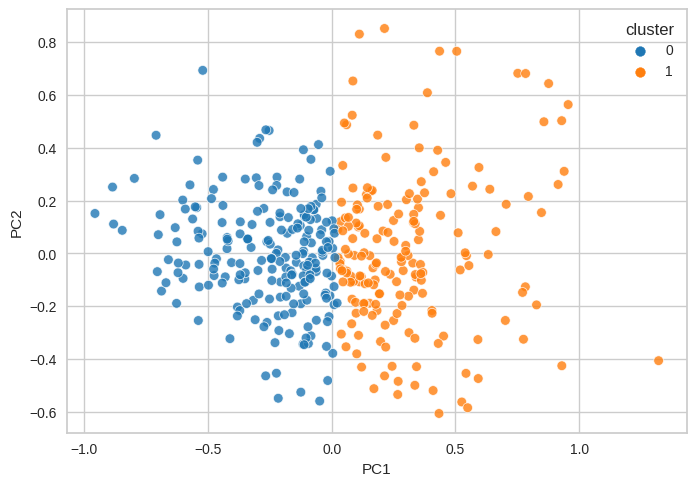

In [ ]:
# Create K-Means Cluster Model
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

seed = 1234 # Used for reproducibility

kmeans = KMeans(n_clusters=2, n_init = 10, random_state=seed)
k_fit = kmeans.fit(model)
centroids = kmeans.cluster_centers_
predictions = k_fit.labels_

# Develop 2 PCA components for visualizations
pca = PCA(2)
pca_data = pd.DataFrame(pca.fit_transform(model),columns=['PC1','PC2'])

pca_data['cluster'] = pd.Categorical(predictions)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data, palette='tab10', alpha=0.8)

In [ ]:
#pca_data.to_excel('pcaCV_work_s_clusters.xlsx', index=False)

#Latent Class Analysis

In [ ]:
from sklearn.model_selection import ParameterGrid

# Create LCA model
model = StepMix(n_components=3, measurement="categorical", verbose=1, random_state=123, n_init=10)

grid = {
    'n_components': [2, 3, 4, 5, 6, 7, 8, 9],
    'n_steps' : [1]
}

results = dict(param_n_steps=[], param_n_components=[], aic=[], bic=[])


# Same model and grid as above
for g in ParameterGrid(grid):
    model.set_params(**g)
    model.fit(data_lca)
    results['param_n_steps'].append(g['n_steps'])
    results['param_n_components'].append(g['n_components'])
    results['aic'].append(model.aic(data_lca))
    results['bic'].append(model.bic(data_lca))

# Save results to a dataframe
results = pd.DataFrame(results)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 13.05it/s, max_LL=-1.68e+3, max_avg_LL=-4.23]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 12 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.9561 0.0439 0.9627 0.0373 0.9521 0.0479 0.9200 0.0800 0.8284 0.1716
 0.9113 0.0887 0.9317 0.0683 0.8386 0.1614 0.9832 0.0168 0.9424 0.0576
 0.9636 0.0364 0.9664 0.0336]
        Class 2 : [0.6312 0.3688 0.5794 0.4206 0.5333 0.4667 0.4977 0.5023 0.3981 0.6019
 0.5074 0.4926 0.6791 0.3209 0.3568 0.6432 0.7375 0.2625 0.5979 0.4021
 0.4994 0.5006 0.8435 0.1565]
    Class weights
        Class 1 : 0.80
        Class 2 : 0.20
    Fit for 2 latent classes
    Estimation method             : 1-step
    Number of observations        : 397
    Number of latent clas

Initializations (n_init) : 100%|██████████| 10/10 [00:06<00:00,  1.57it/s, max_LL=-1.65e+3, max_avg_LL=-4.16]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 12 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.9361 0.0639 0.9590 0.0410 0.9638 0.0362 0.9015 0.0985 0.7414 0.2586
 0.6185 0.3815 0.8195 0.1805 0.3660 0.6340 1.0000 0.0000 1.0000 0.0000
 0.9706 0.0294 0.9634 0.0366]
        Class 2 : [0.9617 0.0383 0.9592 0.0408 0.9426 0.0574 0.9175 0.0825 0.8398 0.1602
 1.0000 0.0000 0.9550 0.0450 1.0000 0.0000 0.9762 0.0238 0.9196 0.0804
 0.9545 0.0455 0.9673 0.0327]
        Class 3 : [0.5839 0.4161 0.5311 0.4689 0.4784 0.5216 0.4600 0.5400 0.4058 0.5942
 0.5356 0.4644 0.7106 0.2894 0.3674 0.6326 0.6967 0.3033 0.5386 0.4614
 0.4421 0.5579 0.8237 0.1763]
    Class w

Initializations (n_init) : 100%|██████████| 10/10 [00:08<00:00,  1.17it/s, max_LL=-1.64e+3, max_avg_LL=-4.12]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 12 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.5952 0.4048 0.5987 0.4013 0.6054 0.3946 0.7307 0.2693 0.4089 0.5911
 0.3154 0.6846 0.0000 1.0000 0.1157 0.8843 0.6054 0.3946 0.6530 0.3470
 0.2598 0.7402 0.7502 0.2498]
        Class 2 : [0.6042 0.3958 0.5287 0.4713 0.4512 0.5488 0.3540 0.6460 0.4301 0.5699
 0.6293 0.3707 1.0000 0.0000 0.4790 0.5210 0.7507 0.2493 0.5172 0.4828
 0.5039 0.4961 0.8626 0.1374]
        Class 3 : [0.9629 0.0371 0.9637 0.0363 0.9448 0.0552 0.9215 0.0785 0.8407 0.1593
 1.0000 0.0000 0.9522 0.0478 1.0000 0.0000 0.9774 0.0226 0.9215 0.0785
 0.9542 0.0458 0.9678 0.0322]
        Cla

Initializations (n_init) : 100%|██████████| 10/10 [00:16<00:00,  1.65s/it, max_LL=-1.62e+3, max_avg_LL=-4.08]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 12 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.6961 0.3039 0.5789 0.4211 0.5325 0.4675 0.4517 0.5483 0.5296 0.4704
 0.6593 0.3407 1.0000 0.0000 0.5377 0.4623 0.8388 0.1612 0.6487 0.3513
 0.6140 0.3860 0.9129 0.0871]
        Class 2 : [0.6546 0.3454 0.7088 0.2912 0.6758 0.3242 0.8550 0.1450 0.4727 0.5273
 0.3744 0.6256 0.0000 1.0000 0.1506 0.8494 0.6803 0.3197 0.7787 0.2213
 0.3571 0.6429 0.7210 0.2790]
        Class 3 : [0.9652 0.0348 0.9691 0.0309 0.9457 0.0543 0.9249 0.0751 0.8404 0.1596
 1.0000 0.0000 0.9501 0.0499 1.0000 0.0000 0.9791 0.0209 0.9242 0.0758
 0.9577 0.0423 0.9676 0.0324]
        Cla

Initializations (n_init) : 100%|██████████| 10/10 [00:11<00:00,  1.18s/it, max_LL=-1.61e+3, max_avg_LL=-4.05]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 12 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.9681 0.0319 0.9745 0.0255 0.9442 0.0558 0.9357 0.0643 0.8420 0.1580
 1.0000 0.0000 0.9549 0.0451 1.0000 0.0000 0.9798 0.0202 0.9249 0.0751
 0.9571 0.0429 0.9676 0.0324]
        Class 2 : [1.0000 0.0000 0.8442 0.1558 0.6702 0.3298 0.0985 0.9015 0.3131 0.6869
 0.7433 0.2567 0.8523 0.1477 0.5966 0.4034 0.8261 0.1739 0.7166 0.2834
 0.7702 0.2298 0.8653 0.1347]
        Class 3 : [0.4774 0.5226 0.1997 0.8003 0.5589 0.4411 0.6813 0.3187 1.0000 0.0000
 0.7250 0.2750 1.0000 0.0000 0.5815 0.4185 0.9433 0.0567 0.6917 0.3083
 0.4651 0.5349 1.0000 0.0000]
        Cla

Initializations (n_init) : 100%|██████████| 10/10 [00:15<00:00,  1.50s/it, max_LL=-1.6e+3, max_avg_LL=-4.04]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 12 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.2631 0.7369 0.3732 0.6268 0.3817 0.6183 0.1891 0.8109 0.0000 1.0000
 0.3826 0.6174 0.5971 0.4029 0.1649 0.8351 0.4064 0.5936 0.0000 1.0000
 0.0728 0.9272 0.6165 0.3835]
        Class 2 : [0.9570 0.0430 0.9721 0.0279 0.9976 0.0024 0.9944 0.0056 0.8604 0.1396
 0.6929 0.3071 0.8997 0.1003 0.3633 0.6367 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 0.9673 0.0327]
        Class 3 : [0.5217 0.4783 0.4069 0.5931 0.3929 0.6071 0.7181 0.2819 0.6092 0.3908
 0.4164 0.5836 0.6946 0.3054 0.1881 0.8119 0.8008 0.1992 0.7446 0.2554
 0.6213 0.3787 1.0000 0.0000]
        Cla

Initializations (n_init) : 100%|██████████| 10/10 [00:15<00:00,  1.55s/it, max_LL=-1.6e+3, max_avg_LL=-4.03]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 12 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.7598 0.2402 0.8932 0.1068 0.8303 0.1697 0.9203 0.0797 0.6011 0.3989
 0.4094 0.5906 0.0000 1.0000 0.1800 0.8200 0.6129 0.3871 0.7710 0.2290
 0.2528 0.7472 0.5983 0.4017]
        Class 2 : [1.0000 0.0000 0.6102 0.3898 0.4776 0.5224 0.2580 0.7420 0.4636 0.5364
 0.8459 0.1541 1.0000 0.0000 0.6622 0.3378 0.7450 0.2550 0.5605 0.4395
 0.5938 0.4062 0.8363 0.1637]
        Class 3 : [1.0000 0.0000 0.9657 0.0343 0.8886 0.1114 0.9164 0.0836 0.7981 0.2019
 1.0000 0.0000 0.9149 0.0851 1.0000 0.0000 1.0000 0.0000 0.8486 0.1514
 1.0000 0.0000 1.0000 0.0000]
        Cla

Initializations (n_init) : 100%|██████████| 10/10 [00:17<00:00,  1.72s/it, max_LL=-1.59e+3, max_avg_LL=-4]

MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 12 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.9560 0.0440 0.9607 0.0393 1.0000 0.0000 1.0000 0.0000 0.8791 0.1209
 0.9016 0.0984 0.9228 0.0772 0.7487 0.2513 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 0.9215 0.0785]
        Class 2 : [0.0000 1.0000 0.6964 0.3036 1.0000 0.0000 1.0000 0.0000 0.7007 0.2993
 0.7149 0.2851 0.8921 0.1079 0.6829 0.3171 0.8645 0.1355 0.9595 0.0405
 0.7500 0.2500 0.9614 0.0386]
        Class 3 : [1.0000 0.0000 1.0000 0.0000 0.8905 0.1095 0.1976 0.8024 0.0000 1.0000
 0.5433 0.4567 0.5914 0.4086 0.4894 0.5106 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000]
        Cla

In [ ]:
results[['param_n_components', 'aic', 'bic']].round().astype(int)

,param_n_components,aic,bic
0,2,3408,3507
1,3,3378,3530
2,4,3376,3579
3,5,3369,3624
4,6,3368,3675
5,7,3384,3743
6,8,3405,3815
7,9,3406,3868
